In [1]:
from MemSE import ROOT
from MemSE.nas import AccuracyDataset
import torch
import json
import matplotlib as mpl
import matplotlib.pyplot as plt

memse_dataset = AccuracyDataset(ROOT / 'experiments/conference_2/results')

dataset = json.load(open( ROOT / 'experiments/conference_2/results/acc.dict'))
power_ascending = sorted(dataset.items(), key=lambda v: v[1]['power'])
pareto_front = []
raw_points = []
to_save = {}
for v in power_ascending:
    k = v[0]
    v = v[1]
    raw_points.append((v['power'], v['top1']))
    if not pareto_front:
        pareto_front.append((v['power'], v['top1']))
        to_save[v['power']] = {'arch': json.loads(k), 'perf': (v['top1'], v['power'])}
        continue
    if v['top1'] > pareto_front[-1][1]:
        pareto_front.append((v['power'], v['top1']))
        to_save[v['power']] = {'arch': json.loads(k), 'perf': (v['top1'], v['power'])}

#TODO regenerate with the current API (GA_ResultFileParser compliant)
to_save = {0: {'pop': to_save}}
#torch.save(to_save, f'{ROOT}/experiments/conference_2/results/ga_results_dataset.pth')

/home/sebwood/projects/def-franlp/sebwood/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = ROOT / 'experiments/conference_2/results/ga_evals_dataset.pth'
results = torch.load(save_path).values()
ga_dataset = {
    'pf': ([], []),
    'estimators': ([], [])
}
for v in results:
    ga_dataset['pf'][0].append(v['pow'][1])
    ga_dataset['pf'][1].append(v['acc'][1])
    ga_dataset['estimators'][0].append(v['pow'][0])
    ga_dataset['estimators'][1].append(v['acc'][0])

In [3]:
def process_saved(save_path):
    results = torch.load(save_path).values()
    ga_const_power_ascending = sorted(results, key=lambda v: v['pow'][1])
    ga_dataset = {
        'pf': ([], []),
        'estimators': ([], []),
        'multed': ([], [])
    }
    def treat_v(v):
        ga_dataset['pf'][0].append(v['pow'][1])
        ga_dataset['pf'][1].append(v['acc'][1])
        ga_dataset['estimators'][0].append(memse_dataset.inverse_transform_power(v['pow'][0]))
        ga_dataset['estimators'][1].append(v['acc'][0] * 100)
    for v in ga_const_power_ascending:
        if not ga_dataset['pf'][1]:
            treat_v(v)
            continue
        if v['acc'][1] > ga_dataset['pf'][1][-1]:
            treat_v(v)
    
    for sub_dict in results: # for each const optimized
        ga_dataset['multed'][0].append([])
        ga_dataset['multed'][1].append([])
        for k, v in sub_dict.items(): # acc, pow and mults dicts
            if k == 'acc' or k == 'pow':
                continue
            ga_dataset['multed'][0][-1].append(v['pow'][1])
            ga_dataset['multed'][1][-1].append(v['acc'][1])
    return ga_dataset


# Old format for GA saves
ga_const = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_const_AccuracyPredictor.pth')
ga_const_sigmoid = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_const_SigmoidAccuracyPredictor.pth')
ga = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_AccuracyPredictor.pth')
ga_sigmoid = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_SigmoidAccuracyPredictor.pth')

gap_const = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_pymoo_const_AccuracyPredictor.pth')
gap_const_sigmoid = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_pymoo_const_SigmoidAccuracyPredictor.pth')
gap = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_pymoo_AccuracyPredictor.pth')
gap_sigmoid = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_pymoo_SigmoidAccuracyPredictor.pth')

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])


In [23]:
class GA_ResultFileParser:
    """Utility class for GA result following the format:"""
    # results.items() -> gen, gen_data
    # gen_data.items() -> pop, exec_time, n_batch, pop_size
    # pop.items() -> arch, perf (tuple), acc (tuple), pow (tuple), mult? (optional)
    # mult.items() -> acc (tuple), pow (tuple)
    def __init__(self, path: str) -> None:
        self.results = torch.load(path)
        assert 'exec_time' in list(self.results.values())[0]
        
    def get_generations(self):
        return self.results.keys()
    
    def max_gen(self):
        return max(self.get_generations())
    
    def get_pareto_front_overall(self):
        vals = {}
        for g, gv in self.results.items():
            pop = gv['pop']
            vals |= {f'{g}_{i}': p for i, p in pop.items()}
        return self.compute_pareto_front(vals)
    
    def get_pareto_front_for_gen(self, gen: int):
        assert gen in self.results
        d = self.results[gen]
        repr_str = f'Gen={gen} (exec_time={d["exec_time"]:.2} - n_batch={d["n_batch"]:.0} - pop_size={d["pop_size"]})'
        result = self.compute_pareto_front(d["pop"])
        return result, repr_str
        
    def compute_pareto_front(self, pop_dict):
        sorted_power_ascending = sorted(pop_dict.values(), key=lambda v: v['pow'][1])
        result = ([],[])
        for v in sorted_power_ascending:
            if not result[1]:
                result[0].append(v['pow'][1])
                result[1].append(v['acc'][1])
                continue
            if v['acc'][1] > result[1][-1]:
                result[0].append(v['pow'][1])
                result[1].append(v['acc'][1])
        return result
    
    def get_gen_color(self, gen: int):
        viridis = mpl.colormaps['viridis']
        return viridis(gen / self.max_gen())
    
# New format for GA saves
ga_direct = GA_ResultFileParser(ROOT / 'experiments/conference_2/results/ga_evals_pymoo_simdirect.pth')

s, r = ga_direct.get_pareto_front_for_gen(ga_direct.max_gen())

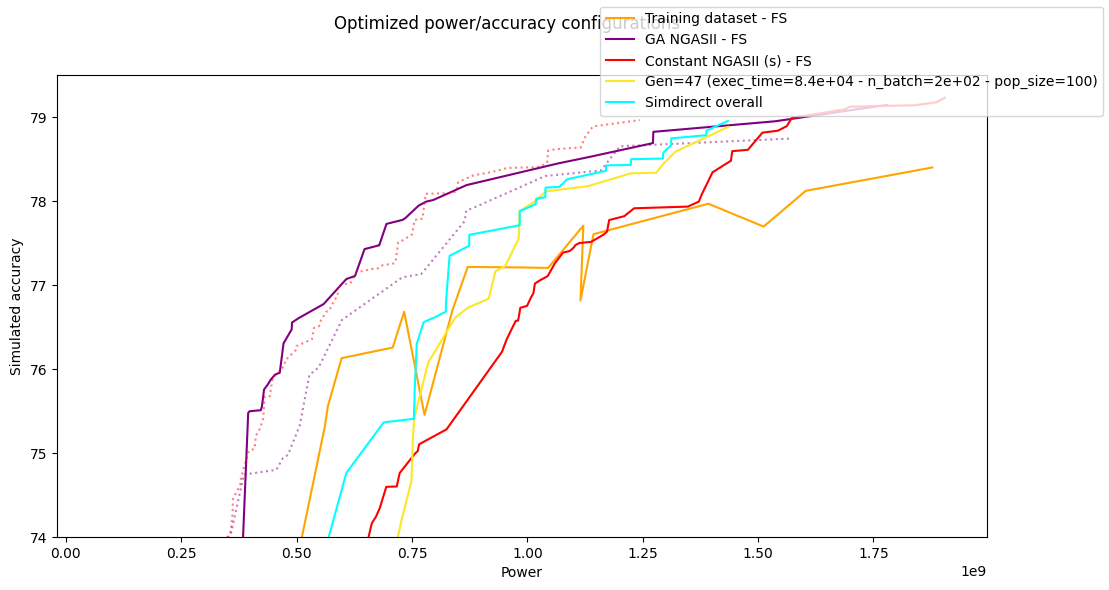

In [25]:
fig, ax = plt.subplots(figsize=(12,6))

def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=False):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    return pf_X, pf_Y

def plot_dict(d, name, color, no_estimators=False, no_multed=False, multed_simplification=True):
    ax.plot(*d['pf'], label=f'{name} - FS', color=color)
    if not no_estimators:
        ax.plot(*d['estimators'], label=f'{name}', linestyle='--', color=color)
    if 'multed' in d and not no_multed:
        if multed_simplification:
            m_fusion_a, m_fusion_p = [], []
            for i in range(len(d['multed'][0])):
                m_fusion_a.extend(d['multed'][1][i])
                m_fusion_p.extend(d['multed'][0][i])
            pf_p, pf_a = plot_pareto_frontier(m_fusion_p, m_fusion_a)
            ax.plot(pf_p, pf_a, color=color, linestyle='dotted', alpha=0.5)
        else:
            for i in range(len(d['multed'][0])):
                pows, accs = d['multed'][0][i], d['multed'][1][i]
                zipped = list(zip(pows, accs))
                sort_z = sorted(zipped, key=lambda x: x[0])
                ax.plot([s[0] for s in sort_z], [s[1] for s in sort_z], color=color, linestyle='dotted', alpha=0.5)

fig.suptitle('Optimized power/accuracy configurations')
ax.set_xlabel('Power')
ax.set_ylabel('Simulated accuracy')
#ax.plot([v[0] for v in pareto_front], [v[1] for v in pareto_front], label='Training dataset (original)', linestyle='-.', color='orange', marker='*')
plot_dict(ga_dataset, name='Training dataset', color='orange', no_estimators=True)
#plot_dict(ga, name='GA', color='red')
#plot_dict(ga_const, name='Constant', color='blue', no_estimators=True)

plot_dict(gap, name='GA NGASII', color='purple', no_estimators=True)
#plot_dict(gap_const, name='Constant NGASII', color='cyan')

#plot_dict(gap_sigmoid, name='GA NGASII (s)', color='pink', no_estimators=True)
plot_dict(gap_const_sigmoid, name='Constant NGASII (s)', color='red', no_estimators=True)

# Simdirect results
r, s = ga_direct.get_pareto_front_for_gen(ga_direct.max_gen())
ax.plot(*r, label=s, color=ga_direct.get_gen_color(ga_direct.max_gen()))

r = ga_direct.get_pareto_front_overall()
ax.plot(*r, label='Simdirect overall', color="cyan")

#ax.scatter([v[0] for v in raw_points], [v[1] for v in raw_points], label='Training dataset', color='gray', alpha=0.5, zorder=-1, linestyle=':')
fig.legend()
plt.ylim(bottom=74, top=79.5)
plt.show()

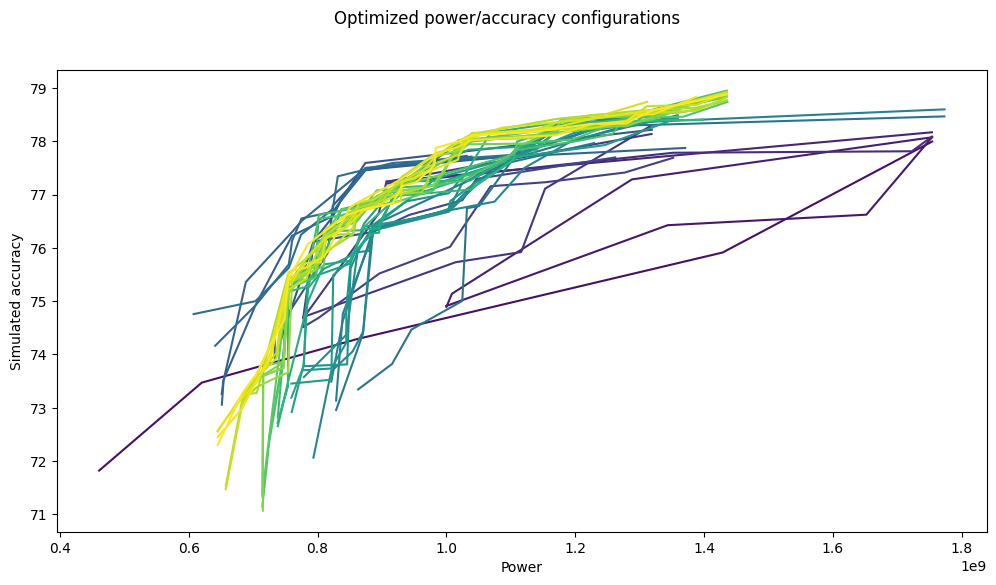

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Optimized power/accuracy configurations')
ax.set_xlabel('Power')
ax.set_ylabel('Simulated accuracy')
# Simdirect results
for g in ga_direct.get_generations():
    s, r = ga_direct.get_pareto_front_for_gen(g)
    ax.plot(*r, label=s, color=ga_direct.get_gen_color(g))

#ax.scatter([v[0] for v in raw_points], [v[1] for v in raw_points], label='Training dataset', color='gray', alpha=0.5, zorder=-1, linestyle=':')
plt.show()

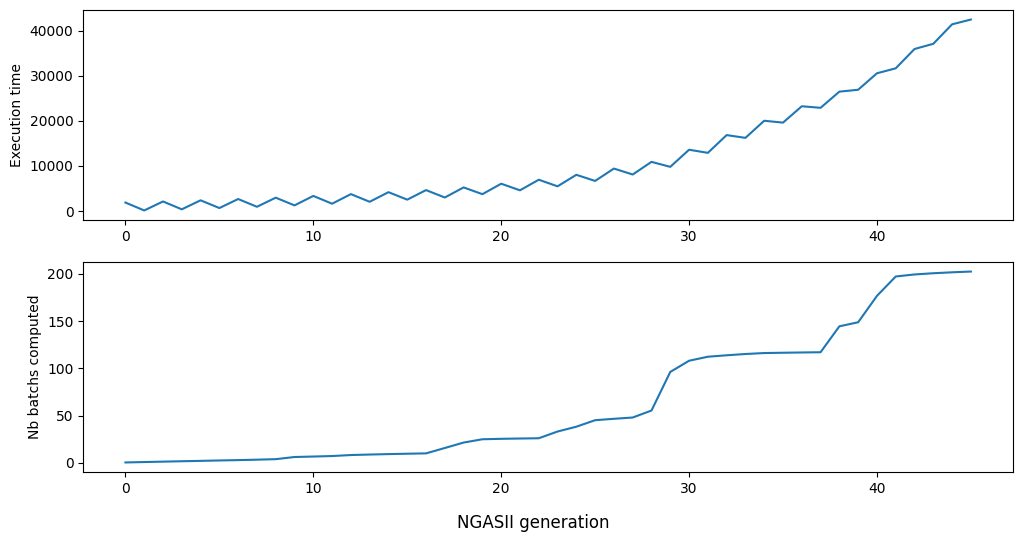

In [28]:
exec_time = []
n_batch = []
for g in ga_direct.get_generations():
    if exec_time:
        t = ga_direct.results[g]['exec_time'] - exec_time[-1]
    else:
        t = ga_direct.results[g]['exec_time']
    exec_time.append(t)
    n_batch.append(ga_direct.results[g]["n_batch"])
fig, ax = plt.subplots(figsize=(12,6), nrows=2)
fig.supxlabel('NGASII generation')
ax[0].plot(exec_time)
ax[0].set_ylabel('Execution time')
ax[1].plot(n_batch)
ax[1].set_ylabel('Nb batchs computed')
plt.show()